<a href="https://colab.research.google.com/github/economicactivist/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [720]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


 Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [721]:
df = df.query("BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'") 
filter_crit = (df.SALE_PRICE > 100000) & (df.SALE_PRICE < 2000000)
df = df.query("@filter_crit")

df.SALE_PRICE.describe()

count    3.151000e+03
mean     6.285601e+05
std      2.929904e+05
min      1.040000e+05
25%      4.475000e+05
50%      5.680000e+05
75%      7.600000e+05
max      1.955000e+06
Name: SALE_PRICE, dtype: float64

In [722]:
1.955000e+06

1955000.0

In [0]:
df['dt_SALE_DATE'] = pd.to_datetime(df.SALE_DATE)

In [724]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151 entries, 44 to 23035
Data columns (total 22 columns):
BOROUGH                           3151 non-null object
NEIGHBORHOOD                      3151 non-null object
BUILDING_CLASS_CATEGORY           3151 non-null object
TAX_CLASS_AT_PRESENT              3151 non-null object
BLOCK                             3151 non-null int64
LOT                               3151 non-null int64
EASE-MENT                         0 non-null float64
BUILDING_CLASS_AT_PRESENT         3151 non-null object
ADDRESS                           3151 non-null object
APARTMENT_NUMBER                  1 non-null object
ZIP_CODE                          3151 non-null float64
RESIDENTIAL_UNITS                 3151 non-null float64
COMMERCIAL_UNITS                  3151 non-null float64
TOTAL_UNITS                       3151 non-null float64
LAND_SQUARE_FEET                  3151 non-null object
GROSS_SQUARE_FEET                 3151 non-null float64
YEAR_BUILT   

In [0]:
df = df.drop(["ADDRESS", "APARTMENT_NUMBER", "EASE-MENT"], axis=1)

In [0]:
train = df[df.dt_SALE_DATE.dt.month_name().isin(["January", "February", "March"])]

In [0]:
test = df.drop(train.index, axis=0)

In [728]:
df.shape[0]== train.shape[0] + test.shape[0]   

True

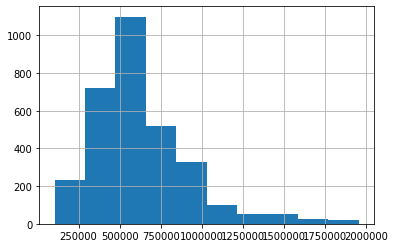

In [729]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df.SALE_PRICE.hist()

In [0]:
train = train.drop(["SALE_DATE", "dt_SALE_DATE", "BUILDING_CLASS_CATEGORY"], axis=1)

In [0]:
test = test.drop(["SALE_DATE", "dt_SALE_DATE", "BUILDING_CLASS_CATEGORY"], axis=1)

In [0]:
y_train = train.SALE_PRICE
y_test = test.SALE_PRICE
X_train = train.drop(y_train.name, axis=1)
X_test =  test.drop(y_test.name, axis=1)

In [0]:
# TODO
from category_encoders import OneHotEncoder
encoder = OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

In [734]:
X_train.shape, X_train_enc.shape

((2507, 15), (2507, 933))

In [735]:
X_train.TAX_CLASS_AT_TIME_OF_SALE.value_counts()   #LOT, BLOCK, ZIP_CODE, LAND_SQUARE_FEET, GROSS_SQUARE_FEET, YEAR_BUILT, TAX_CLASS_AT_TIME_OF_SALE

1    2507
Name: TAX_CLASS_AT_TIME_OF_SALE, dtype: int64

In [0]:
col_to_drop = "BLOCK LAND_SQUARE_FEET TAX_CLASS_AT_TIME_OF_SALE".split()  #YEAR_BUILT ZIP_CODE LOT GROSS_SQUARE_FEET

In [0]:
cols_to_keep = [x for x in X_train.columns if x not in col_to_drop]  #list of columns to keep

In [0]:
X_train_2 = X_train[cols_to_keep]

In [0]:
X_test_2 = X_test[cols_to_keep]

In [740]:
X_test_2.shape, X_train_2.shape

((644, 12), (2507, 12))

In [0]:
encoder = OneHotEncoder(use_cat_names=True)
X_train_enc2 = encoder.fit_transform(X_train_2)
X_test_enc2 = encoder.transform(X_test_2)

In [742]:
X_train_enc2.shape, X_test_enc2.shape

((2507, 44), (644, 44))

In [0]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=15)

In [0]:
X_train_selected = selector.fit_transform(X_train_enc2, y_train)

In [0]:
X_test_selected = selector.transform(X_test_enc2)

In [746]:
X_train_selected.shape, X_test_selected.shape

((2507, 15), (644, 15))

In [747]:
X_train_enc2.columns[selector.get_support()]

Index(['BOROUGH_3', 'BOROUGH_2', 'BOROUGH_5', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A3',
       'ZIP_CODE', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S1'],
      dtype='object')

In [748]:
X_train_enc2.columns[~selector.get_support()]

Index(['BOROUGH_4', 'BOROUGH_1', 'NEIGHBORHOOD_BEDFORD STUYVESANT',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A0', 'BUILDING_CLASS_AT_PRESENT_A2',
       'BUILDING_CLASS_AT_PRESENT_S1', 'BUILDING_CLASS_AT_PRESENT_A4',
       'BUILDING_CLASS_AT_PRESENT_A6', 'BUILDING_CLASS_AT_PRESENT_A8',
       'BUILDING_CLASS_AT_PRESENT_B2', 'BUILDING_CLASS_AT_PRESENT_S0',
       'BUILDING_CLASS_AT_PRESENT_B3', 'RESIDENTIAL_UNITS', 'YEAR_BUILT',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A2',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A8',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S0'],
      dtype='object')

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train_enc2.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_enc2, y_train)
    X_test_selected = selector.transform(X_test_enc2)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

##Lowest MAE is $167,991

In [750]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(X_train_enc2, y_train)
ridge.alpha_

0.01

In [752]:
ridge.predict(X_test_enc2).min()

155444.43976469524